In [1]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data_raw <- read_csv("data/players.csv")
sessions_data_raw <- read_csv("data/sessions.csv")
players_data_raw
sessions_data_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [3]:
players_data <- players_data_raw |>
                    drop_na()
sessions_data <- sessions_data_raw |>
                    mutate(across(c(start_time, end_time), dmy_hm))
players_data
sessions_data

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<dttm>,<dttm>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-28 15:36:00,2024-07-28 15:57:00,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,2024-07-25 06:15:00,2024-07-25 06:22:00,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-20 02:26:00,2024-05-20 02:45:00,1.71617e+12,1.71617e+12


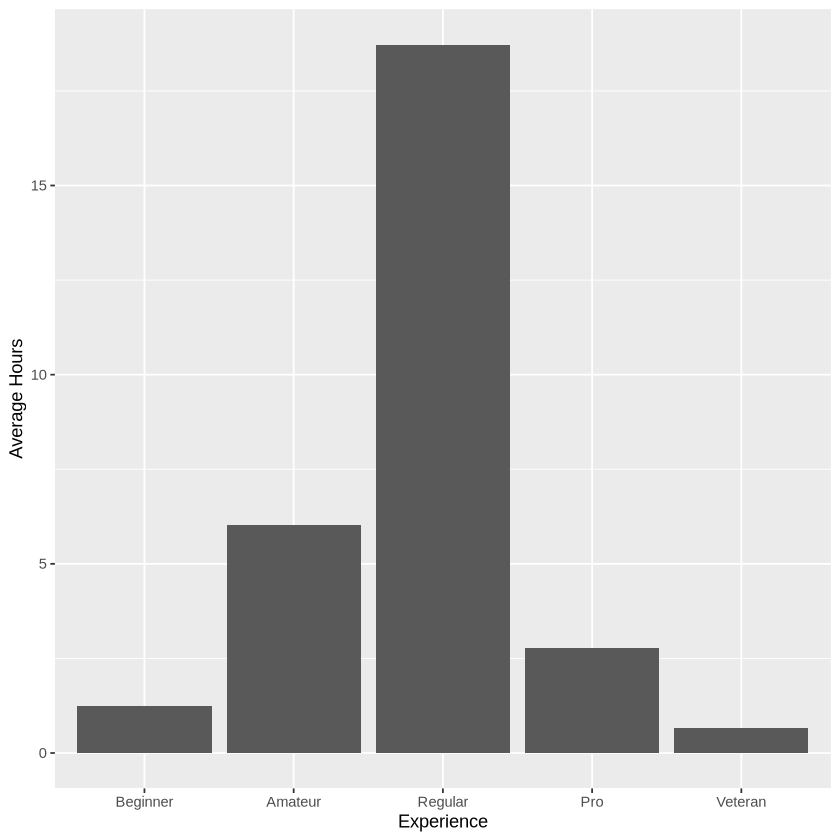

In [4]:
players_data |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))) |>
    group_by(experience) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = experience, y = avg_hrs)) +
        geom_bar(stat = "identity") +
        xlab("Experience") +
        ylab("Average Hours")

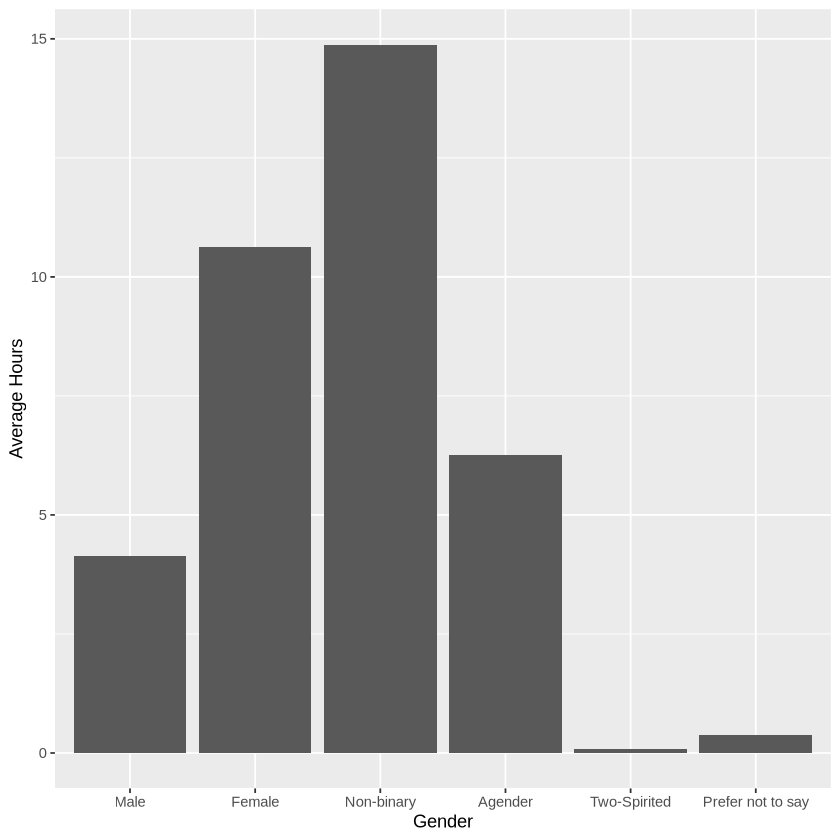

In [5]:
players_data |>
    mutate(gender = factor(gender, levels = c("Male", "Female", "Non-binary", "Agender", "Two-Spirited", "Prefer not to say"))) |>
    group_by(gender) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = gender, y = avg_hrs)) +
        geom_bar(stat = "identity") +
        xlab("Gender") +
        ylab("Average Hours")

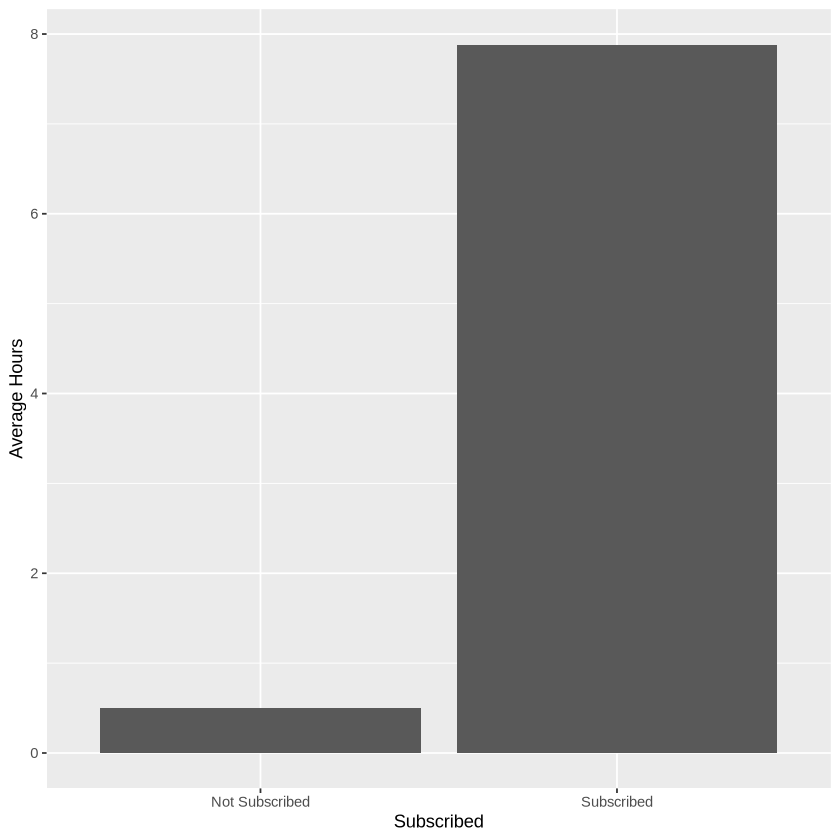

In [6]:
players_data |>
    group_by(subscribe) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = subscribe, y = avg_hrs)) +
        geom_bar(stat = "identity") +
        xlab("Subscribed") +
        ylab("Average Hours") +
        scale_x_discrete(labels = c("FALSE" = "Not Subscribed", "TRUE" = "Subscribed"))

Warning message:
“`position_stack()` requires non-overlapping x intervals.”


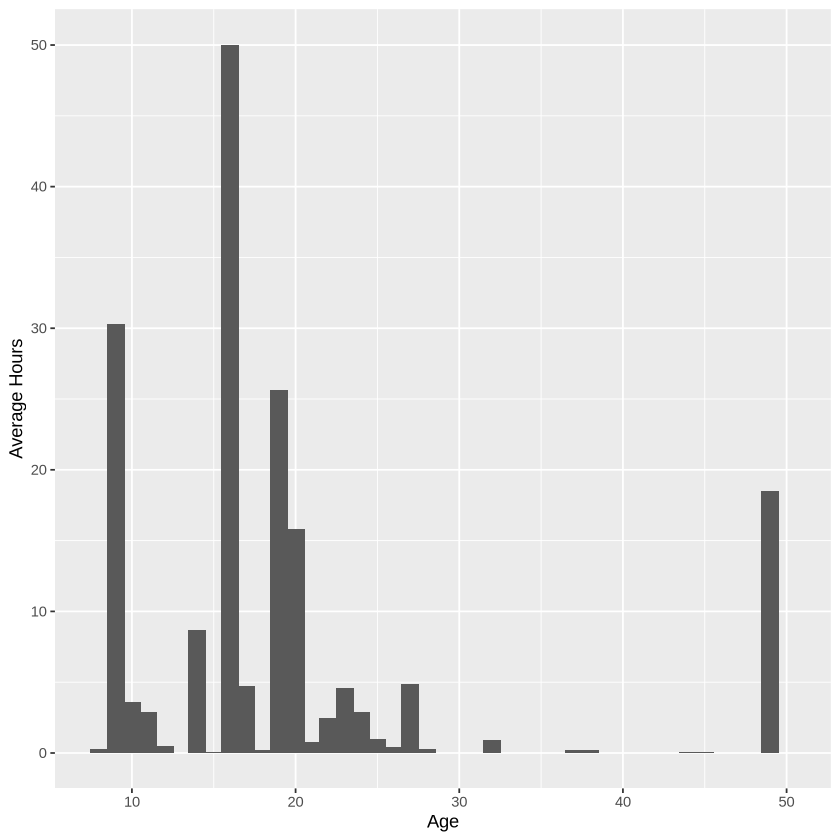

In [7]:
players_data |>
    group_by(Age) |>
    summarize(avg_hrs = mean(played_hours)) |>
    ggplot(aes(x = Age, y = avg_hrs)) +
        geom_bar(stat = "identity", width = 1.1) +
        xlab("Age") +
        ylab("Average Hours")

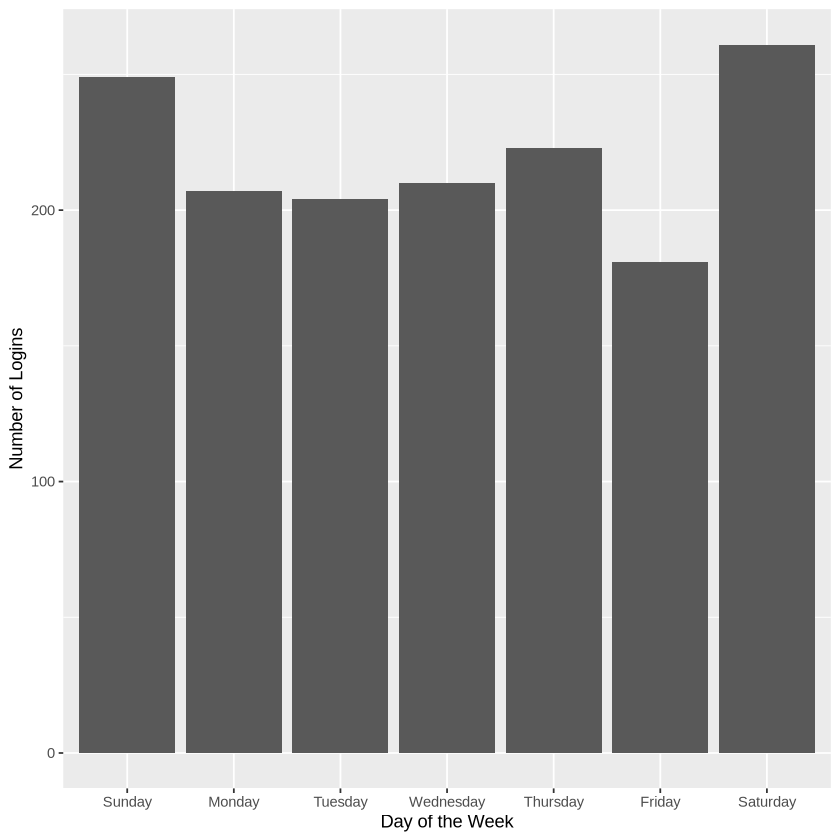

In [8]:
sessions_data |>
    mutate(day_of_week = weekdays(start_time), day_of_week = factor(day_of_week, levels = c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"))) |>
    group_by(day_of_week) |>
    summarize(count = n()) |>
    ggplot(aes(x = day_of_week, y = count)) +
        geom_bar(stat = "identity") +
        xlab("Day of the Week") +
        ylab("Number of Logins")

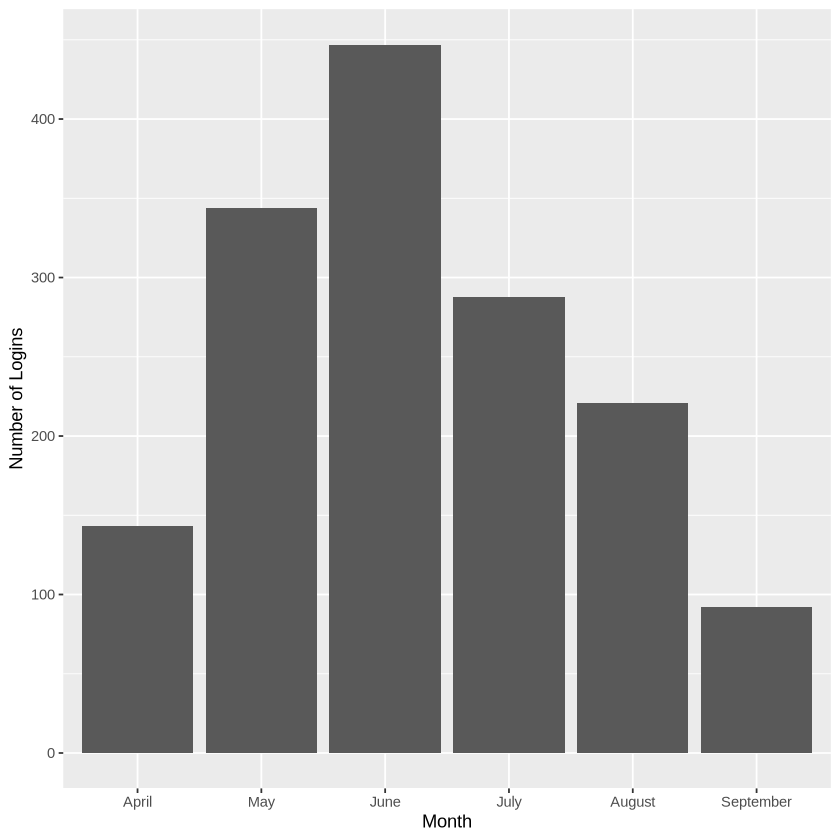

In [20]:
sessions_data |>
    mutate(month = factor(months(start_time), levels = month.name)) |>
    group_by(month) |>
    summarize(count = n()) |>
    ggplot(aes(x = month, y = count)) +
        geom_bar(stat = "identity") +
        xlab("Month") +
        ylab("Number of Logins")

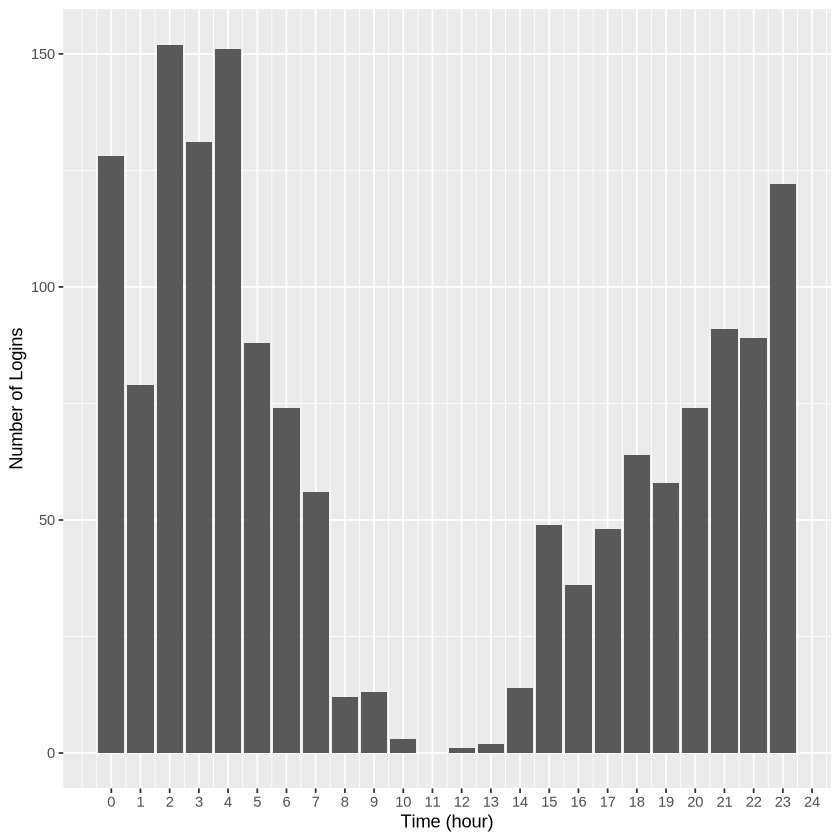

In [29]:
sessions_data |>
    mutate(time = hour(start_time)) |>
    group_by(time) |>
    summarize(count = n()) |>
    ggplot(aes(x = time, y = count)) +
        geom_bar(stat = "identity") +
        xlab("Time (hour)") +
        ylab("Number of Logins") +
        scale_x_continuous(breaks = seq(0, 24, by = 1))